In [8]:
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, UpSampling2D
from keras.models import Sequential

%matplotlib inline

# RGB to grayscale (dimention reduction)
def convert_to_normalized_grayscale(array):

    a = np.zeros(shape=(array.shape[0], array.shape[1]))    
    
    #convert the image to grayscale and normalize the data
    for i in range(0, array.shape[0]):
        for j in range(0, array.shape[1]):
            a[i,j] = max(array[i,j,0], array[i,j,1], array[i,j,2]) / 255
    
    return a 

In [35]:
batchCounter = 1

batchSize = 400
dataSize = 3200
totalBatches = math.floor(dataSize / batchSize)

def load_next_batch():
    
    global batchCounter
    global training_input
    global testing_input
    global training_target
    global testing_target
    
    if batchCounter == totalBatches:
        batchCounter = 1

    batchStart = (batchSize * batchCounter) - batchSize + 1

    train_size = int(batchSize * 0.80);

    input_row_count = 72
    input_column_count = 72
    input_data = np.zeros((batchSize, input_row_count, input_column_count))

    for i in range(0, batchSize):
        newImg = np.array(Image.open("input/input_" + str(batchStart + i) + ".jpg"))
        newImg = convert_to_normalized_grayscale(newImg)
        input_data[i,:,:] = newImg

    training_input = input_data[0:train_size,:,:]
    testing_input = input_data[train_size:,:,:]

    target_row_count = 121 #121
    target_column_count = 180 #180
    target_data = np.zeros((batchSize, target_row_count, target_column_count))

    for i in range(0, batchSize):
        newImg = np.array(Image.open("target/target_" + str(batchStart + i) + ".jpg"))
        newImg = convert_to_normalized_grayscale(newImg)
        #crop
        #newImg = newImg[0:target_row_count, 0:target_column_count]
        target_data[i,:,:] = newImg

    #since tensorflow requires a 4D tesor as input, we put the values in in a fourth dimention.
    input_data = input_data.reshape(input_data.shape[0], input_row_count, input_column_count, 1)
    target_data = target_data.reshape(target_data.shape[0], target_row_count, target_column_count, 1)

    #splitting input data into training and validation
    training_input = input_data[0:train_size,:,:,:]
    testing_input = input_data[train_size:,:,:,:]

    #release the initial array from memory
    del input_data

    #splitting target data into training and validation
    training_target = target_data[0:train_size,:,:,:]
    testing_target = target_data[train_size:,:,:,:]

    del target_data
    
    batchCounter += 1

    print("done")

In [11]:
load_next_batch()

done


In [36]:
input_shape = (training_input.shape[1], training_input.shape[2], training_input.shape[3])
dropout = 0.4;

model1 = Sequential()
model1.add(Conv2D(12, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model1.add(Flatten())
model1.add(Dense(1176, activation='relu'))
model1.add(Dropout(dropout))
model1.add(Dense(1176, activation='relu'))
model1.add(Reshape((28, 42,1)))
model1.add(Conv2DTranspose(16, kernel_size=(5, 6), strides=(2, 2), activation='relu'))
model1.add(BatchNormalization(momentum=0.9))
model1.add(Conv2DTranspose(1, kernel_size=(5, 6), strides=(2, 2), activation='sigmoid')) 
model1.summary()

# For a mean squared error regression problem
model1.compile(optimizer='rmsprop',
              loss='sme')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 34, 34, 12)        312       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 12)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 24)          7224      
_________________________________________________________________
flatten_5 (Flatten)          (None, 1176)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1176)              1384152   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1176)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1176)              1384152   
__________

In [50]:
#tain with all batches
for i in range(0, totalBatches * 1): # runs through the whole dataset x times
    
    model1.fit(training_input, training_target, epochs=5, batch_size=batchSize)

    score = model1.evaluate(testing_input, testing_target, batch_size=testing_target.shape[0])
    
    load_next_batch()

Epoch 1/5
320/320 [==============================] - 1s - loss: 0.0646
Epoch 2/5
320/320 [==============================] - 2s - loss: 0.0586
Epoch 3/5
320/320 [==============================] - 1s - loss: 0.0578
Epoch 4/5
320/320 [==============================] - 2s - loss: 0.0573
Epoch 5/5
80/80 [==============================] - 0s
done
Epoch 1/5
320/320 [==============================] - 2s - loss: 0.0707
Epoch 2/5
320/320 [==============================] - 2s - loss: 0.0663
Epoch 3/5
320/320 [==============================] - 2s - loss: 0.0603
Epoch 4/5
320/320 [==============================] - 2s - loss: 0.0584
Epoch 5/5
80/80 [==============================] - 0s
done
Epoch 1/5
320/320 [==============================] - 2s - loss: 0.0690
Epoch 2/5
320/320 [==============================] - 2s - loss: 0.0637
Epoch 3/5
320/320 [==============================] - 2s - loss: 0.0633
Epoch 4/5
320/320 [==============================] - 2s - loss: 0.0622
Epoch 5/5
80/80 [=============

In [51]:
score

0.096538931131362915

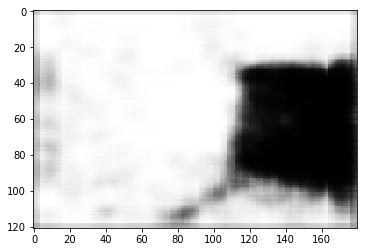

In [65]:
generated = model1.predict(testing_input[0:50,:,:,:])
plt.imshow(generated[45,:,:,0], cmap='gray', interpolation='nearest')

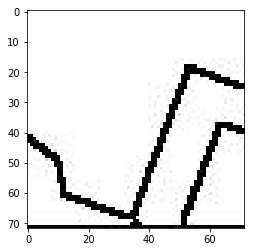

In [66]:
plt.imshow(testing_input[45,:,:,0], cmap='gray', interpolation='nearest')

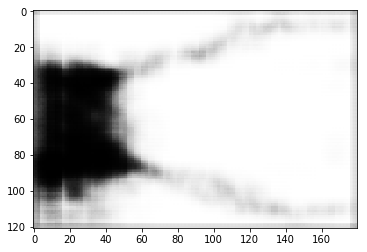

In [67]:
plt.imshow(generated[19,:,:,0], cmap='gray', interpolation='nearest')

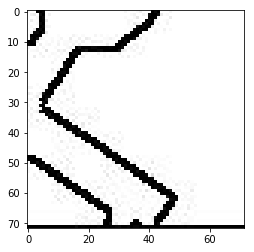

In [68]:
plt.imshow(testing_input[19,:,:,0], cmap='gray', interpolation='nearest')

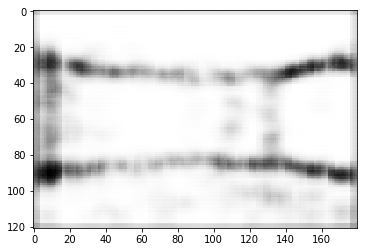

In [69]:
plt.imshow(generated[30,:,:,0], cmap='gray', interpolation='nearest')

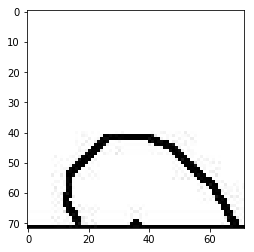

In [70]:
plt.imshow(testing_input[30,:,:,0], cmap='gray', interpolation='nearest')